In [3]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
from pprint import pprint

In [4]:
json_path="./data/implementations.json"
with open(json_path) as f:
    data = json.load(f)

In [16]:
mandelbrot32 = []
mandelbrot64 = []
simd32 = []
simd64 = []

for d in data["datapoints"]:
    avg_time = np.asarray(list(map(lambda x: x["computationTime"],
                   sorted(d["data"]["workers"], key=lambda x: x["rank"]))))
    #avg_time=[np.average(avg_time)]
    if d["implementation"] == "mandelbrot32":
        mandelbrot32.extend(avg_time)
    elif d["implementation"] == "mandelbrot64":
        mandelbrot64.extend(avg_time)
    elif d["implementation"] == "mandelbrotsimd32":
        simd32.extend(avg_time)
    elif d["implementation"] == "mandelbrotsimd64":
        simd64.extend(avg_time)

# time in ms
mandelbrot32 = np.asarray(mandelbrot32)
mandelbrot64 = np.asarray(mandelbrot64)
simd32 = np.asarray(simd32)
simd64 = np.asarray(simd64)
print(mandelbrot32, mandelbrot64, simd32, simd64)


[1038033  708172  996793  956760  380090  452680  380043  379377  379850
  252781   49787  282943  379929  192563  380122  322823  105995   18532
   26415  160345  379645  388207  379477  396927  171407  176361  282529
  379447  150526    9718    8586    8025  154667   70917  164605  160065
  375492  230352   92749  192968  122632  505461  160963  122240   90866
  121274  221658  626747  227946  380053   16754  198651   53523   23879
  168359  158800  313791  379655  194005  380084  119275   24671   24402
  227207   34062   29953   23087   21255   45398   43187   41413   41079
   98703   96171  184712  142919  141933  182773  121458  138599   91809
   96519   49914  113670  141379   99194  141543   93569   93256   63613
   90738   94183  121905  138632   91170  183397  120474  136163   91021
   92732   46349   93118   93989   61724  139943   92694   93264   62299
 2279824 1140119 3420044 3419127 3421202 3420714 2280371 3419464 2279870
 2279404 1140495 3506245 3419654 3505299 3422052 22

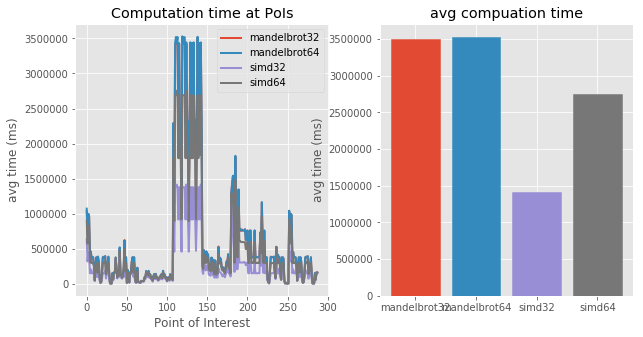

In [17]:
# Data for plotting
x = np.arange(len(simd64))
names = ["mandelbrot32", "mandelbrot64", "simd32", "simd64"]

plt.style.use('ggplot')
fig, (line, bar) = plt.subplots(1, 2, figsize=(10,5))
p0 = line.plot(x, mandelbrot32, label=names[0], lw=2)
p1 = line.plot(x, mandelbrot64, label=names[1], lw=2)
p2 = line.plot(x, simd32, label=names[2], lw=2)
p3 = line.plot(x, simd64, label=names[3], lw=2)
line.legend()

line.set(xlabel='Point of Interest', ylabel='avg time (ms)',
       title='Computation time at PoIs')
line.grid(True)

avg = np.asarray([np.max(mandelbrot32), np.max(mandelbrot64), np.max(simd32), np.max(simd64)])
x_avg = np.arange(len(avg))

barlist = bar.bar(x_avg, avg)
# set colors of bars to match colors in line plot
barlist[0].set_color(p0[0].get_color())
barlist[1].set_color(p1[0].get_color())
barlist[2].set_color(p2[0].get_color())
barlist[3].set_color(p3[0].get_color())

bar.set_xticks(x_avg)
bar.set_xticklabels(names)
bar.set(ylabel="avg time (ms)",
       title="avg compuation time")
bar.grid(True)

# fig.savefig("impl_test.svg", format="svg")
plt.show()

2.5500365946101367
(1.0056610894452132, 1.0099421092373522, 0.9960851480303401, 1.0311774055508007, 1.0843037974683545, 1.0635451505016722, 1.1040864488883368, 1.0671132910635244, 1.1189407023603914, 1.1278544105714616, 1.22234404122355, 1.3720416018344117, 1.0669773221497358, 1.0784897292250233, 1.0840596665691722, 1.1823441063581244, 1.2419042495965573, 1.2760647678084753, 1.235919773095624, 1.2999104273144002, 1.066324882932343, 1.0323335543507937, 1.376516544117647, 1.5334071435448156, 1.6199942927803672, 1.1760377898654453, 1.1871972020755095, 1.195752692637816, 1.250013767277934, 1.3521106216634091, 1.1101471900089206, 1.106402364496989, 1.464569701593263, 1.833607365998027, 1.2553475935828877, 1.4137749375844615, 1.0655994222436207, 1.4422066347200038, 1.4612257086415215, 1.5114964675658318, 1.4392377318667045, 1.438281994605885, 1.4014889410601754, 1.2202511246894514, 1.373155719156383, 1.3125837741233444, 1.4047116466110965, 1.4075522031091896, 1.4087662238973828, 1.4059462983

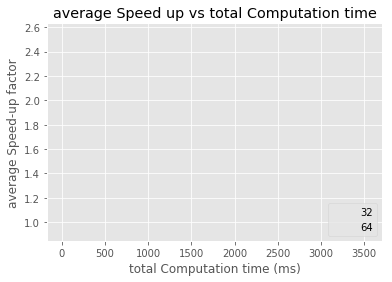

In [20]:
# Plot speed up versus computation time
speedup32 = mandelbrot32/simd32
speedup64 = mandelbrot64/simd64
print(max(speedup32))
m32, s32 = zip(*sorted(zip(mandelbrot32, speedup32), key=lambda x: x[0]))
print(s32)
m64, s64 = zip(*sorted(zip(mandelbrot64, speedup64), key=lambda x: x[0]))

plt.style.use('ggplot')
fig = plt.subplot()
p0 = fig.plot(np.asarray(m32)/1000, np.asarray(s32), label='32', lw=0)
p1 = fig.plot(np.asarray(m64)/1000, np.asarray(s64), label='64', lw=0)
fig.legend()

fig.set(xlabel='total Computation time (ms)', ylabel='average Speed-up factor',
       title='average Speed up vs total Computation time')
fig.grid(True)

plt.savefig("speedupvscomptime.svg", format="svg")
plt.savefig("speedupvscomptime.png", format="png")
plt.show()

In [19]:
const32 = simd32 - (mandelbrot32/4) 
# We need number of pixels worked on by a worker for correct computation
print(const32)

[378248.75 144273.   201879.75 169158.    58099.5   92985.    58214.25
  58263.75  58228.5  180319.75  32552.25  68767.25  58177.75  50716.25
  58286.5   54177.25  25420.25  12462.    18168.25  32693.75  62402.75
  55907.25  58277.75  96528.25  35166.25 123469.75 216363.75  58397.25
  32800.5    6255.5    5926.5    5939.75  31511.25  31544.75 115177.75
 117795.75 231229.   134194.    55152.75 124263.    76083.   247824.75
  51146.25  76171.    51748.5   65855.5   47635.5  105217.25  43102.5
  58027.75   8022.5   38840.25  29255.25  12743.25  97275.25  98584.
  79927.25  62462.25  55647.75  62325.    25190.25  12811.25  13643.5
  41785.25  12510.5   14271.75  12818.25  12663.25  24968.5   25320.25
  24529.75  24660.25  46024.25  42729.25  89916.    64090.25  64890.75
  84661.75  55282.5   64011.25  42273.75  42200.25  21602.5   44452.5
  63405.25  42587.5   63319.25  42881.75  44395.    27630.75  42059.5
  41785.25  55303.75  63024.    42110.5   84501.75  55289.5   61705.25
  43530.75  